In [43]:
import torch as tc 
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split 


import torchvision as tv 
from torchvision import transforms as T 
from torchvision import datasets 
from torchvision import models 

from torchmetrics import Accuracy

from tqdm import tqdm 

import numpy as np 
import matplotlib.pyplot as plt 

import copy

In [17]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=10).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)

            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item() * 100

In [20]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=10).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item() * 100

In [21]:
train_transform = T.Compose([T.ToTensor(),
                             T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = T.Compose([T.ToTensor(), 
                            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [22]:
train_dataset = datasets.CIFAR10(root =  '/home/ahmadrezabaqerzadeh/datasets/', train = True, download = True, transform = train_transform)
test_dataset  = datasets.CIFAR10(root = '/home/ahmadrezabaqerzadeh/datasets/', train = False, download = True, transform = test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [24]:
model = models.mobilenet_v2().to(device)

In [25]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [26]:
model.classifier[1] = nn.Linear(1280, 10)

In [27]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [28]:
model = model.to(device)

In [37]:
optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 5e-4)
loss_func = nn.CrossEntropyLoss()

In [30]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

best_loss = tc.inf 
best_model = [0]

In [38]:
start, end = 25, 30
for i in range(start, end):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,test_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = copy.deepcopy(model)
    print('model saved!')

Epoch=25: 100%|██████████| 1563/1563 [01:02<00:00, 24.81batch/s, Accuracy=93, loss=0.21]   


valid loss=0.7625, accuracy=77.04



Epoch=26: 100%|██████████| 1563/1563 [01:08<00:00, 22.80batch/s, Accuracy=93.8, loss=0.187]


valid loss=0.7828, accuracy=76.73



Epoch=27: 100%|██████████| 1563/1563 [01:09<00:00, 22.35batch/s, Accuracy=94.3, loss=0.175]


valid loss=0.7927, accuracy=76.63



Epoch=28: 100%|██████████| 1563/1563 [00:59<00:00, 26.47batch/s, Accuracy=94.6, loss=0.169]


valid loss=0.8047, accuracy=76.85



Epoch=29: 100%|██████████| 1563/1563 [00:49<00:00, 31.63batch/s, Accuracy=94.7, loss=0.16] 


valid loss=0.8112, accuracy=76.87



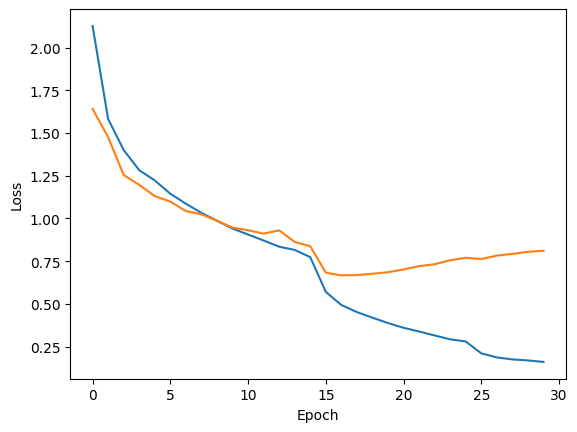

In [39]:
plt.plot(range(end), loss_train_hist, label = 'Train Loss') 
plt.plot(range(end), loss_valid_hist, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

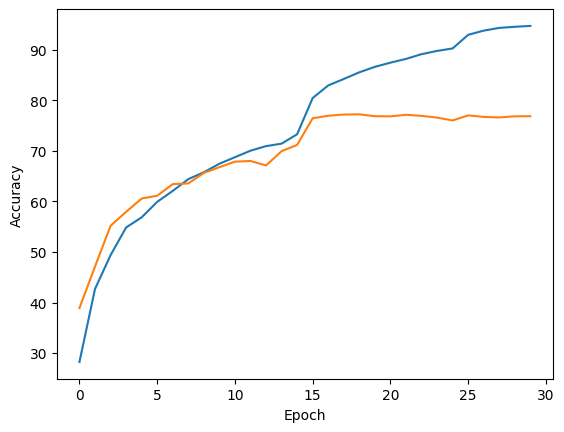

In [41]:
plt.plot(range(end), acc_train_hist, label = 'Train Accurcay') 
plt.plot(range(end), acc_valid_hist, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()